In [1]:
#MOUNT GOOGLE DRIVE
#if your datasets are not stored in gdrive, skip this
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#IMPORT REQUIRED LIBRARIES
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from scipy.sparse import isspmatrix_dok #is this needed now? double check
from scipy.integrate import trapz #for AOC

In [3]:
def find_folders_with_pattern(path, pattern): #this will look only for files exactly in path (wont traverse further with good file name)
    matching_folders = []

    # Regex pattern for matching three-digit number followed by a letter
    regex_pattern = re.compile(pattern)

    for root, dirs, files in os.walk(path):
        for folder in dirs:
            if regex_pattern.match(folder) and len(folder) == 4:
                matching_folders.append(os.path.join(root, folder))
        # Stop traversing into subdirectories
        dirs.clear()

    return matching_folders

# Example usage
#path = '/path/to/your/folder'
#pattern = r'\d{3}[a-zA-Z]'
#matching_folders = find_folders_with_pattern(path, pattern)

# Print the matching folders
#for folder in matching_folders:
#    print(folder)


In [4]:
PATH = 'gdrive/MyDrive/HabonJackie/GRAB2.0/'  #enter: path to data location
pattern = r'\d{3}[a-zA-Z]' #3 digits followed by initial
folders = find_folders_with_pattern(PATH,pattern)

In [5]:
#FUNCTION TO COMBINE DATAFRAMES BY CONDITION
def combineByCondition(condition):
  dfs = [] #this will be the combined data frames
  for i in range(0,len(folders)):
    files = os.listdir(folders[i])
    for file in files:
      if condition in file and 'Output' in file:
        df = pd.read_csv(folders[i]+'/'+file) #single data frame from 1 iteraiton
        df["DamID"] = folders[i].split("/")[-1] #append a DamID column with the identity of the animal that was run
        dfs.append(df)
  # Concatenate all DataFrames in the list vertically
  combined_df = pd.concat(dfs, ignore_index=True)

  # Get column names that contain 'Trial'
  trial_columns = [col for col in combined_df.columns if 'Trial' in col]

  # Calculate average of selected columns
  average_values = combined_df[trial_columns].mean(axis=1)

  # Append average column to DataFrame
  combined_df['Average'] = average_values

  # Print the combined DataFrame
  return(combined_df)

In [6]:
#COMBINE DATAFRAMES BY CONDITION AND PLOT WITH A TRACE PER INDIVIDUAL
def combineAndPlotIndividuals(conditions):
  color_map = {}  # Dictionary to store colors for each DAMID
  global DamIDs
  global condition_df

  conditions = conditions.split(",")
  fig, axes = plt.subplots(1, len(conditions), sharey='row')
  #DamIDs = combined_df

  for i in range(0, len(conditions)):
    condition_df = combineByCondition(conditions[i])  # DataFrame all of the same condition
    DamIDs = condition_df['DamID'].unique()  # List of individuals in the DataFrame

    for k in range(0, len(DamIDs)):
      data = condition_df[condition_df['DamID'] == DamIDs[k]]  # Data from 1 animal, 1 condition...
      X = np.linspace(-10, 10, len(data))  # ...that we add to the subplot...

      if DamIDs[k] not in color_map:
        color_map[DamIDs[k]] = 'C{}'.format(k)  # Assign a unique color to each DAMID

      axes[i].scatter(X, data['Average'], color=color_map[DamIDs[k]])  # ...for the corresponding condition

  # Create custom legend handles for each DAMID
  handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[dam_id]) for dam_id in color_map.keys()]
  labels = color_map.keys()

  # Create a shared legend for all subplots
  fig.legend(handles, labels, loc='upper right', ncol=len(handles)//2)

  plt.show()  # Display the figure


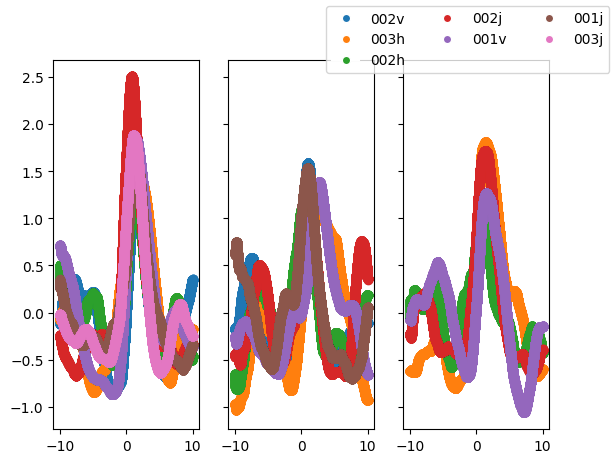

In [7]:
conditions = 'Pre,Post,Ctrl'
combineAndPlotIndividuals(conditions)

In [8]:
def CombineAndPlotGroup(conditions):
    conditions = conditions.split(",")
    fig, axes = plt.subplots(1, len(conditions), sharey='row')
    for i in range(0, len(conditions)):
        condition_df = combineByCondition(conditions[i])  # DataFrame all of the same condition
        avg_df = pd.DataFrame()
        Moms = condition_df['DamID'].unique()
        # ADD MOMS
        for f in range(0, len(Moms)):
            avg_df[Moms[f]] = condition_df['Average'][condition_df['DamID'] == Moms[f]].reset_index(drop=True)

        row_means = avg_df.mean(axis=1)
        row_std_errors = avg_df.sem(axis=1)

        # Generate x-axis values
        X = np.linspace(-10, 10, len(row_means))

        # Plot mean values with shaded standard error
        axes[i].scatter(X, row_means, color='blue', label='Mean', s=1/4)
        axes[i].fill_between(X, row_means - row_std_errors, row_means + row_std_errors, color='lightblue', alpha=0.5, label='Standard Error')

        # Add labels
        axes[i].set_xlabel('X')
        axes[i].set_ylabel('Mean')

    # Create a shared legend for all subplots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    # Show the plot
    plt.show()



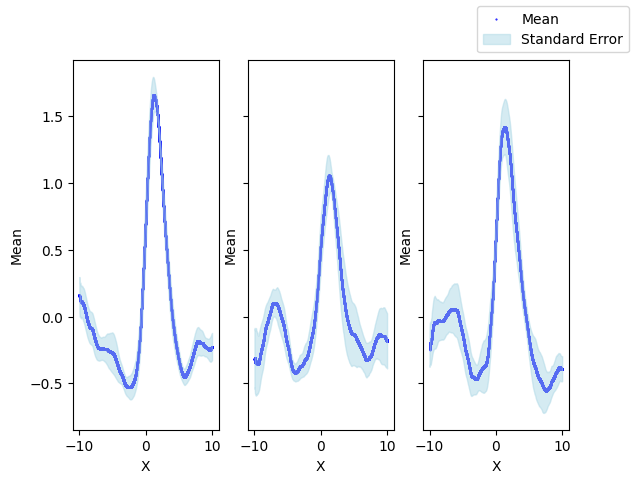

In [9]:
CombineAndPlotGroup(conditions)